In [2]:
!pip install mplfinance
!pip install tensorboardX
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.experimental.output_all_intermediates(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM
from tensorflow.keras import backend as K
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        #X = Flatten(input_shape=input_shape)(X_input)
        #X = LSTM(32,return_sequences = False ,input_shape=input_shape, activation='tanh')(X_input)
        X = LSTM(100, recurrent_activation = 'sigmoid', recurrent_dropout=0, unroll=True)(X_input)
        #X = Dense(512, activation="relu")(X)
        #X = Dense(256, activation="relu")(X)
        #X = Dense(128, activation="relu")(X)
        X = Dense(64, activation="relu")(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(learning_rate=lr))

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def predict(self, state):
        return self.Actor.predict(state)

class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)

        #V = Flatten(input_shape=input_shape)(X_input)
        #V = LSTM(32,return_sequences = False,input_shape=input_shape, activation='tanh')(X_input)
        V = LSTM(100, recurrent_activation = 'sigmoid', recurrent_dropout=0, unroll=True)(X_input)
        #V = Dense(512, activation="relu")(V)
        #V = Dense(256, activation="relu")(V)
        #V = Dense(128, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(learning_rate=lr))

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime, date
import os
import cv2
import numpy as np

def Write_to_file(Date, net_worth, filename='{}.txt'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
    for i in net_worth: 
        Date += " {}".format(i)
    #print(Date)
    if not os.path.exists('logs'):
        os.makedirs('logs')
    file = open("logs/"+filename, 'a+')
    file.write(Date+"\n")
    file.close()

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        #self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

    # Render the environment to the screen
    def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        plt.show(block=False)
        # Necessary to view frames before they are unrendered
        plt.pause(0.001)

        """Display image with OpenCV - no interruption"""
        #####redraw the canvas
        self.fig.canvas.draw()
        ######convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))

        ########img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        #########display image with OpenCV or any operation you like
        #################################
        cv2.imshow("Bitcoin trading bot",image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import copy
import pandas as pd
import numpy as np
import random
from collections import deque
from tensorboardX import SummaryWriter
from tensorflow.keras.optimizers import Adam, RMSprop

class CustomEnv:
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, Render_range = 100):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range # render range in visualization

        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1])

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (self.lookback_window_size, 18)

        # Neural Networks part bellow
        self.lr = 0.00001
        self.epochs = 1
        self.normalize_value = 100000
        self.optimizer = Adam

        # Create Actor-Critic network model
        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)

    # create tensorboard writer
    def create_writer(self):
        self.replay_count = 0
        self.writer = SummaryWriter(comment="Crypto_trader")

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(Render_range=self.Render_range) # init visualization
        self.trades = deque(maxlen=self.Render_range) # limited orders memory for visualization
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        self.episode_orders = 0 # test
        self.env_steps_size = env_steps_size
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
            self.market_history.append([#self.df.loc[current_step, 'Open'],
                                        #self.df.loc[current_step, 'High'],
                                        #self.df.loc[current_step, 'Low'],
                                        self.df.loc[current_step, 'Close'],
                                        #self.df.loc[current_step, 'Volume']
                                        self.df.loc[current_step, 'Volume'],#
                                        #self.df.loc[current_step, 'asset_volume'],#
                                        self.df.loc[current_step, 'num_trades'],#
                                        #self.df.loc[current_step, 'taker_base_volume'],#
                                        #self.df.loc[current_step, 'taker_quote_volume'],#
                                        self.df.loc[current_step, 'SMA_20'],#
                                        self.df.loc[current_step, 'SMA_60'],#
                                        self.df.loc[current_step, 'RSI'],#
                                        self.df.loc[current_step, 'Bollinger_up_20'],
                                        self.df.loc[current_step, 'Bollinger_down_20'],
                                        self.df.loc[current_step, 'DIF'],
                                        self.df.loc[current_step, 'DEA'],
                                        self.df.loc[current_step, 'MACD'],
                                        self.df.loc[current_step, 'OBV'],
                                        self.df.loc[current_step, 'ATR'],
                                        #self.df.loc[current_step, 'Positive_sentiment']                                       						
                                        ])

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append([#self.df.loc[self.current_step, 'Open'],
                                    #self.df.loc[self.current_step, 'High'],
                                    #self.df.loc[self.current_step, 'Low'],
                                    self.df.loc[self.current_step, 'Close'],
                                    #self.df.loc[self.current_step, 'Volume']
                                    self.df.loc[self.current_step, 'Volume'],#
                                    #self.df.loc[self.current_step, 'asset_volume'],#
                                    self.df.loc[self.current_step, 'num_trades'],#
                                    #self.df.loc[self.current_step, 'taker_base_volume'],#
                                    #self.df.loc[self.current_step, 'taker_quote_volume'],#
                                    self.df.loc[self.current_step, 'SMA_20'],#
                                    self.df.loc[self.current_step, 'SMA_60'],#
                                    self.df.loc[self.current_step, 'RSI'],#
                                    self.df.loc[self.current_step, 'Bollinger_up_20'],#
                                    self.df.loc[self.current_step, 'Bollinger_down_20'],#
                                    self.df.loc[self.current_step, 'DIF'],#
                                    self.df.loc[self.current_step, 'DEA'],#
                                    self.df.loc[self.current_step, 'MACD'],#
                                    self.df.loc[self.current_step, 'OBV'],#
                                    self.df.loc[self.current_step, 'ATR'],
                                    #self.df.loc[self.current_step, 'Positive_sentiment']
                                    ])
        #print(pd.DataFrame(self.market_history).shape)
        #print(pd.DataFrame(self.orders_history).shape)

        obs = np.concatenate((self.market_history, self.orders_history), axis=1)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.current_step, 'Open'],
            self.df.loc[self.current_step, 'Close'])
        Date = self.df.loc[self.current_step, 'Date'] # for visualization
        High = self.df.loc[self.current_step, 'High'] # for visualization
        Low = self.df.loc[self.current_step, 'Low'] # for visualization
        
        #if action == 0: # Hold
        #    pass

        if action == 0 and self.balance > self.initial_balance/100: #and p > 0.5:
            # Buy with 100% of current balance
            self.crypto_bought = self.balance / (current_price * 1.0005)
            self.balance -= self.crypto_bought * current_price * 1.0005
            self.crypto_held += self.crypto_bought
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.crypto_bought, 'type': "buy"})
            self.episode_orders += 1

        elif action == 1 and self.crypto_held>0:
            # Sell 100% of current crypto held
            self.crypto_sold = self.crypto_held
            self.balance += (self.crypto_sold * current_price * 0.9995)
            self.crypto_held -= self.crypto_sold
            self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.crypto_sold, 'type': "sell"})
            self.episode_orders += 1

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
        #Write_to_file(Date, self.orders_history[-1])

        # Calculate reward
        reward = self.net_worth - self.prev_net_worth

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation() #/ self.normalize_value
        
        return obs, reward, done

    # render environment
    def render(self, visualize = False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            Date = self.df.loc[self.current_step, 'Date']
            Open = self.df.loc[self.current_step, 'Open']
            Close = self.df.loc[self.current_step, 'Close']
            High = self.df.loc[self.current_step, 'High']
            Low = self.df.loc[self.current_step, 'Low']
            Volume = self.df.loc[self.current_step, 'Volume']

            # Render the environment to the screen
            self.visualization.render(Date, Open, High, Low, Close, Volume, self.net_worth, self.trades)

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.95, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)
        # Compute discounted rewards
        #discounted_r = np.vstack(self.discount_rewards(rewards))

        # Get Critic network predictions 
        values = self.Critic.predict(states)
        next_values = self.Critic.predict(next_states)
        # Compute advantages
        #advantages = discounted_r - values
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        pylab.plot(target,'-')
        pylab.plot(advantages,'.')
        ax=pylab.gca()
        ax.grid(True)
        pylab.show()
        '''
        # stack everything to numpy array
        y_true = np.hstack([advantages, predictions, actions])
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=True)
        c_loss = self.Critic.Critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=True)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1
        

    def normalize_state(self, state):
        #market_obs = state[:,0:1]#
        vol_obs = state[:,1:2]#
        no_trade = state[:,2:3]#

        balance_obs = state[:,13:14]
        networth_obs = state[:,14:15]
        portfolio_obs = state[:,15:]
        
        close_prices = state[:,3:4].mean()
        
        
        market_obs_nml = (state[:,0:1] - state[:,0:1].mean())/state[:,0:1].std()
        #vol_obs_nml = tf.keras.layers.LayerNormalization(axis = 0)(vol_obs).numpy()
        vol_obs_nml = (vol_obs - vol_obs.mean())/vol_obs.std()
        no_trade_nml = (no_trade - no_trade.mean())/no_trade.std()
        i_1 = (state[:,3:4] - state[:,3:4].mean())/state[:,3:4].std()
        i_2 = (state[:,4:5] - state[:,4:5].mean())/state[:,4:5].std()
        i_3 = (state[:,5:6] - state[:,5:6].mean())/state[:,5:6].std()
        i_4 = (state[:,6:7] - state[:,6:7].mean())/state[:,6:7].std()
        i_5 = (state[:,7:8] - state[:,7:8].mean())/state[:,7:8].std()
        i_6 = (state[:,8:9] - state[:,8:9].mean())/state[:,8:9].std()
        i_7 = (state[:,9:10] - state[:,9:10].mean())/state[:,9:10].std()
        i_8 = (state[:,10:11] - state[:,10:11].mean())/state[:,10:11].std()
        i_9 = (state[:,11:12] - state[:,11:12].mean())/state[:,11:12].std()
        i_10 = (state[:,12:13] - state[:,12:13].mean())/state[:,12:13].std()

        #senti = state[:,13:14]




        balance_obs_nml = balance_obs / networth_obs
        networth_obs_nml = networth_obs / self.initial_balance
        portfolio_obs_nml = portfolio_obs
        
        state_nml = np.concatenate((
            market_obs_nml,
            vol_obs_nml,
            no_trade_nml,
            i_1, i_2, i_3, i_4, i_5, i_6, i_7, i_8, i_9, i_10, #senti,   
            balance_obs_nml,
            networth_obs_nml ,
            portfolio_obs_nml), axis=1)
        
        return state_nml


    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(np.expand_dims(state, axis=0))[0]
        action = np.random.choice(self.action_space, p=prediction)
        return action, prediction

    def act_with_max_p(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(np.expand_dims(state, axis=0))[0]
        action = self.action_space[np.argmax(prediction)]
        return action, prediction
  

    def save(self, name="Crypto_trader_with_cost_v4"):
        # save keras model weights
        self.Actor.Actor.save_weights(f"/content/drive/MyDrive/{name}_Actor.h5")
        self.Critic.Critic.save_weights(f"/content/drive/MyDrive/{name}_Critic.h5")

    def load(self, name="Crypto_trader_with_cost"):
        # load keras model weights
        self.Actor.Actor.load_weights(f"{name}_Actor.h5")
        self.Critic.Critic.load_weights(f"{name}_Critic.h5")
        
def Random_games(env, visualize, train_episodes = 50):
    average_net_worth = 0
    for episode in range(train_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action = np.random.randint(3, size=1)[0]
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                print("net_worth:", episode, env.net_worth)
                break

    print("average {} episodes random net_worth: {}".format(train_episodes, average_net_worth/train_episodes))

def train_agent(env, visualize=False, train_episodes = 50, training_batch_size=500):
    ####log
    f = open("trainlog_v4.txt", "a")
    f.writelines("The running log as of " + str(datetime.now()) +"\n")
    f.writelines("episode,net_worth,average,no_orders, \n")
    f.close()
    ####

    env.create_writer() # create TensorBoard writer
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth

    pre_state = 0
    current_state = 0
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)
        signals = 0
        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        g = open("prob_v4.txt", "a")
        for t in range(training_batch_size):
            env.render(visualize)
            state_nml = env.normalize_state(state)
            action, prediction = env.act(state_nml)
            next_state, reward, done = env.step(action) #, prediction[action])
            next_state_nml = env.normalize_state(next_state)
            states.append(np.expand_dims(state_nml, axis=0))
            next_states.append(np.expand_dims(next_state_nml, axis=0))
            action_onehot = np.zeros(env.action_space.shape[0])
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state
            if prediction[1] > prediction[0]:
              current_state = 1 
            elif prediction[1] < prediction[0]:
              current_state = 0
            if pre_state != current_state:
              signals += 1
            pre_state = current_state


            print(f"The probability is {prediction}, net worth:{env.net_worth}, signal: {signals}")

            g.writelines(f"{prediction}\n")
            

            #if t % 10000 == 0:
            #  print(env.net_worth)
        g.close()
        env.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        env.writer.add_scalar('Data/average net_worth', average, episode)
        env.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("net worth {} {:.2f} {:.2f} {}".format(episode, env.net_worth, average, env.episode_orders))
        #if episode > len(total_average):
        # if best_average < average:
        #     best_average = average
        #     print("Saving model")
        #     env.save()

        #if episode % 10 == 0:

        ####log############
        f = open("trainlog_v4.txt", "a")
        f.writelines("{},{:.2f},{:.2f},{},\n".format(episode, env.net_worth, average, env.episode_orders))
        f.close()
        ###################

        #env.save()


def test_agent(env, visualize=True, test_episodes=10):
    #env.load() # load the model
    average_net_worth = 0
    f = open("testlog_v4.txt", "a")
    f.writelines("The running log as of " + str(datetime.now()) +"\n")
    f.writelines("episode,net_worth,no_orders, \n")
    f.close()

    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            state_nml = env.normalize_state(state)
            action, prediction = env.act_with_max_p(state_nml)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                print("net_worth:", episode, env.net_worth, env.episode_orders)
                break
        f = open("testlog_v4.txt", "a")
        f.writelines("{},{:.2f},{},\n".format(episode, env.net_worth, env.episode_orders))
        f.close()
    print("average {} episodes agent net_worth: {}".format(test_episodes, average_net_worth/test_episodes))

In [4]:
df = pd.read_csv('BTC_train_v4.csv').drop(columns=['taker_base_volume','taker_quote_volume'])
df = df.rename(columns = {'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume','close_time':'Date'})
df = df.sort_values('Date')

lookback_window_size = 100
train_df = df
#test_df = df[-720-lookback_window_size:] # 30 days

train_env = CustomEnv(train_df, lookback_window_size=lookback_window_size, initial_balance=10000)
#test_env = CustomEnv(test_df, lookback_window_size=lookback_window_size)


In [5]:
len(df)

731

In [6]:
# train_env.Actor.Actor.save_weights('Crypto_trader_Actor.h5')
# train_env.Critic.Critic.save_weights('Crypto_trader_Critic.h5')

In [7]:
train_env.load("Crypto_trader_with_cost_v4")

In [ ]:
train_agent(train_env, visualize=True, train_episodes=1, training_batch_size=len(df)-lookback_window_size-1)
#test_agent(test_env, visualize=True, test_episodes=1000)
#Random_games(test_env, visualize=False, train_episodes = 1000)

In [15]:
train_env.save("2000Crypto_trader_with_cost_v4")

In [ ]:
from google.colab import files
files.download('LSTM_T1_with_cost_Actor.h5') 
files.download('LSTM_T1_with_cost_Critic.h5') 

In [ ]:
from google.colab import files
files.download('LSTM_T1_Actor.h5') 
files.download('LSTM_T1_Critic.h5') 

#Test

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df_test = pd.read_csv('BTC_test_v4.csv')
df_test = df_test.rename(columns = {'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume','close_time':'Date'})
#df_test = df_test[df_test['Date']<'2021-12-31']
df_test = df_test.sort_values('Date')
lookback_window_size = 100
test_df = df_test
test_env = CustomEnv(test_df, lookback_window_size=lookback_window_size, initial_balance=10000)
test_env.load(name="600Crypto_trader_with_cost_v4")

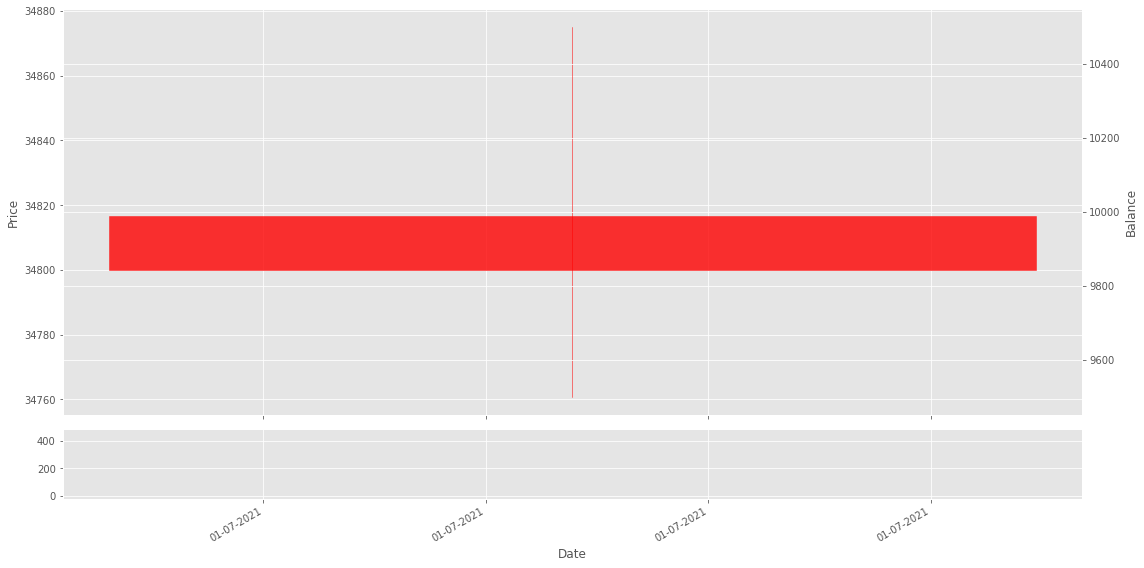

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
test_agent(test_env, visualize=True, test_episodes=1)